# Using xhistogram to convert ocean model output from depth to density coordinates


In [107]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [108]:
# The cluster was created using the dask jupyterlab extension
# Press "+new" to add a cluster and scale it to the size you want
from dask.distributed import Client

client = Client("tcp://10.32.3.81:41727")
client

Client Scheduler: tcp://10.32.3.81:41727 Dashboard: /user/0000-0001-8571-865x/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [113]:
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [118]:
def vertical_rebin(data, bin_data, bins, dz, vert_dim="st_ocean"):
    nanmask = np.isnan(data)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        bin_data.where(~nanmask),
        bins=[bins],
        weights=(data * dz).where(~nanmask),
        dim=[vert_dim],
    )
    return full_sum

def vertical_rebin_wrapper(
    ds,
    bin_data_name,
    bins,
    dz_name="dz",
    vert_dim="st_ocean",
    return_average=True,
    debug=False,
):
    """A wrapper for the core functionality in `vertical_rebin`.
    Accepts datasets and calculates the average over the new depth coordinates.
    """
    ds = ds.copy()
    ds_rebinned = xr.Dataset()
    
    ones = xr.ones_like(ds[dz_name])
    
    dz_rebinned = vertical_rebin(
        ones,
        ds[bin_data_name],
        bins,
        ds[dz_name],
        vert_dim=vert_dim,
    )
    for var in ds.data_vars:
        ds_rebinned[var] = vertical_rebin(
            ds[var], ds[bin_data_name], bins, ds[dz_name], vert_dim=vert_dim
        )
    if return_average:
        ds_rebinned = (
            ds_rebinned / dz_rebinned
        )  # this might cause a lot of overhead...i can try to deactivate if the save fails.

    ds_rebinned[dz_name] = dz_rebinned

    return ds_rebinned

In [128]:
# load the data (I searched for any model that had the required variables
# using @rabernats example:https://nbviewer.jupyter.org/gist/rabernat/2bbe3e4e675d841e86d7e5870692b663)

no3 = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/no3/gn/')
thetao = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/thetao/gn/')
dz = read_data('gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Omon/thkcello/gn/')
ds = xr.merge([thetao, no3, dz])
ds.coords['area'] = ds['area']
# look at just one year as example
ds = ds.isel(time=slice(0,12))

# carry the ocean depth as data_variable
ds['z'] = ds['olevel']

In [129]:
ds

<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, olevel: 75, time: 12, x: 362, y: 332)
Coordinates:
    area            (time, y, x) float32 dask.array<shape=(12, 332, 362), chunksize=(12, 332, 362)>
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<shape=(332, 362, 4), chunksize=(332, 362, 4)>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<shape=(332, 362, 4), chunksize=(332, 362, 4)>
    nav_lat         (y, x) float32 dask.array<shape=(332, 362), chunksize=(332, 362)>
    nav_lon         (y, x) float32 dask.array<shape=(332, 362), chunksize=(332, 362)>
  * olevel          (olevel) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    olevel_bounds   (olevel, axis_nbounds) float32 dask.array<shape=(75, 2), chunksize=(75, 2)>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<shape=(12, 2), chunksize=(12, 2)>
Dimensions without coordinates: axis_nbounds, 

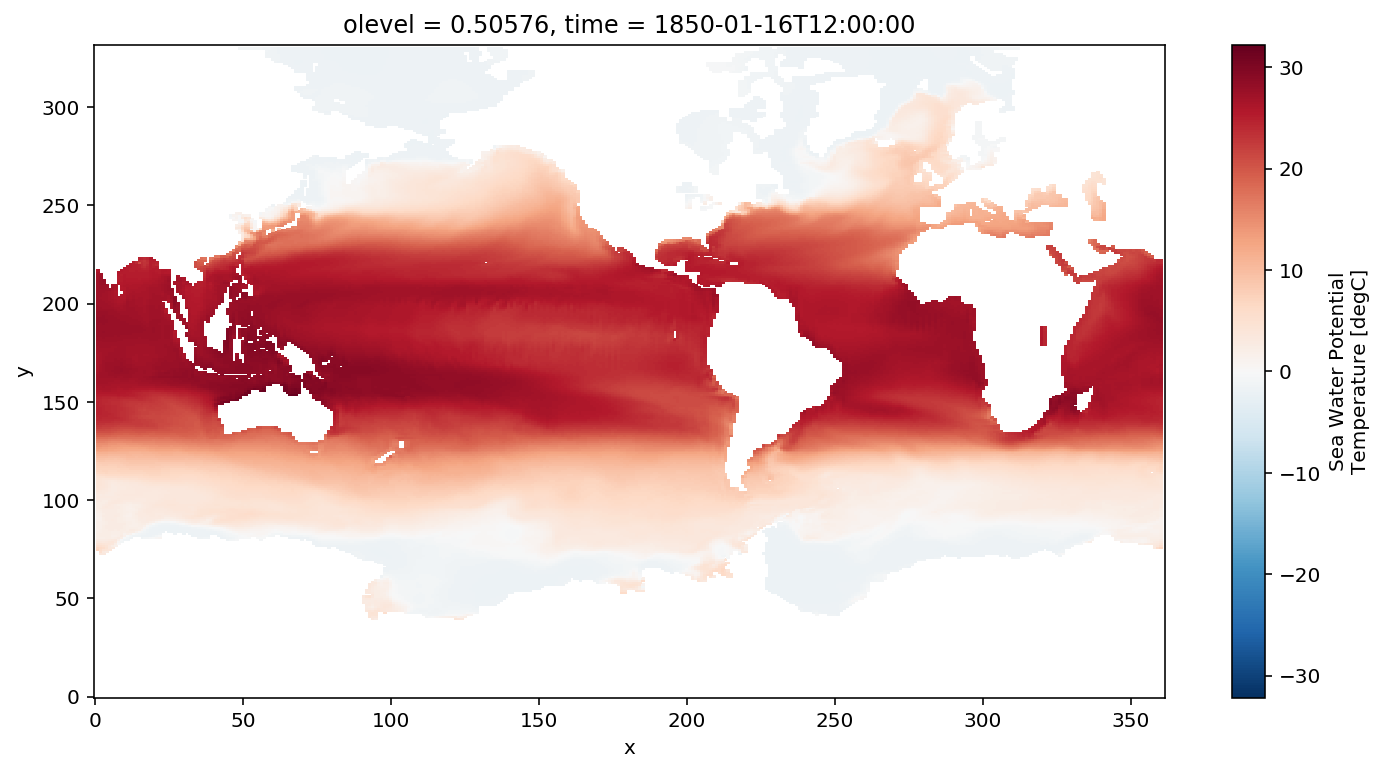

In [116]:
ds.thetao.isel(olevel=0, time=0).plot()

In [133]:
#define bins (in units of potential temperature)
bins = np.arange(-2, 35, 2)

In [134]:
ds_rebinned = vertical_rebin_wrapper(ds,
                                     'thetao',
                                     bins,
                                     dz_name='thkcello',
                                     vert_dim='olevel')

<a list of 16 text.Text objects>

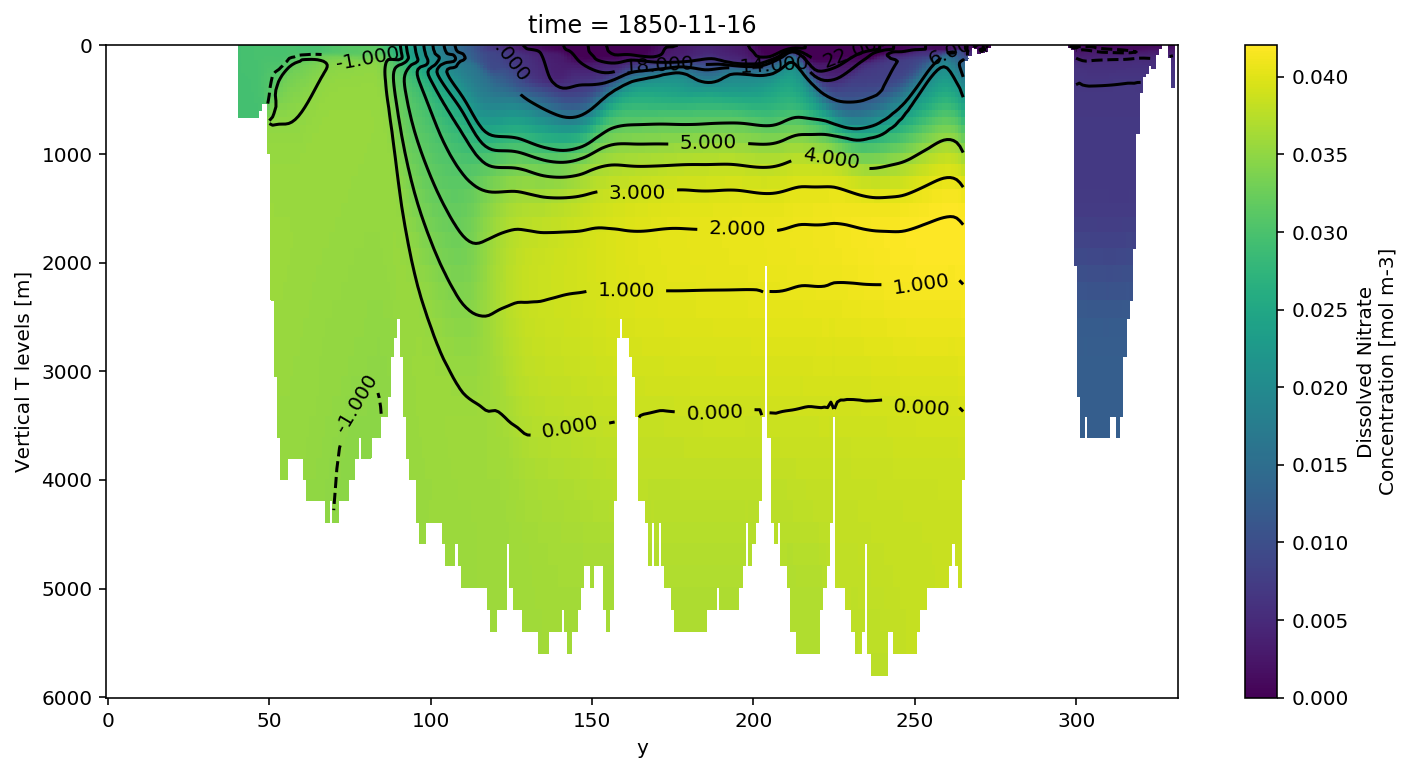

In [140]:
# define a slice along the central pacific and plot it agains depth
roi = dict(x=125, time=10)
ds.no3.isel(**roi).plot(yincrease=False)

#overlay contours of potential temperature
levels = np.concatenate([np.arange(-1, 6), np.arange(6, 30,4)])
ch = ds.thetao.isel(**roi).plot.contour(
    colors='k',
    yincrease=False,
    levels=levels
)
plt.clabel(ch)

<a list of 15 text.Text objects>

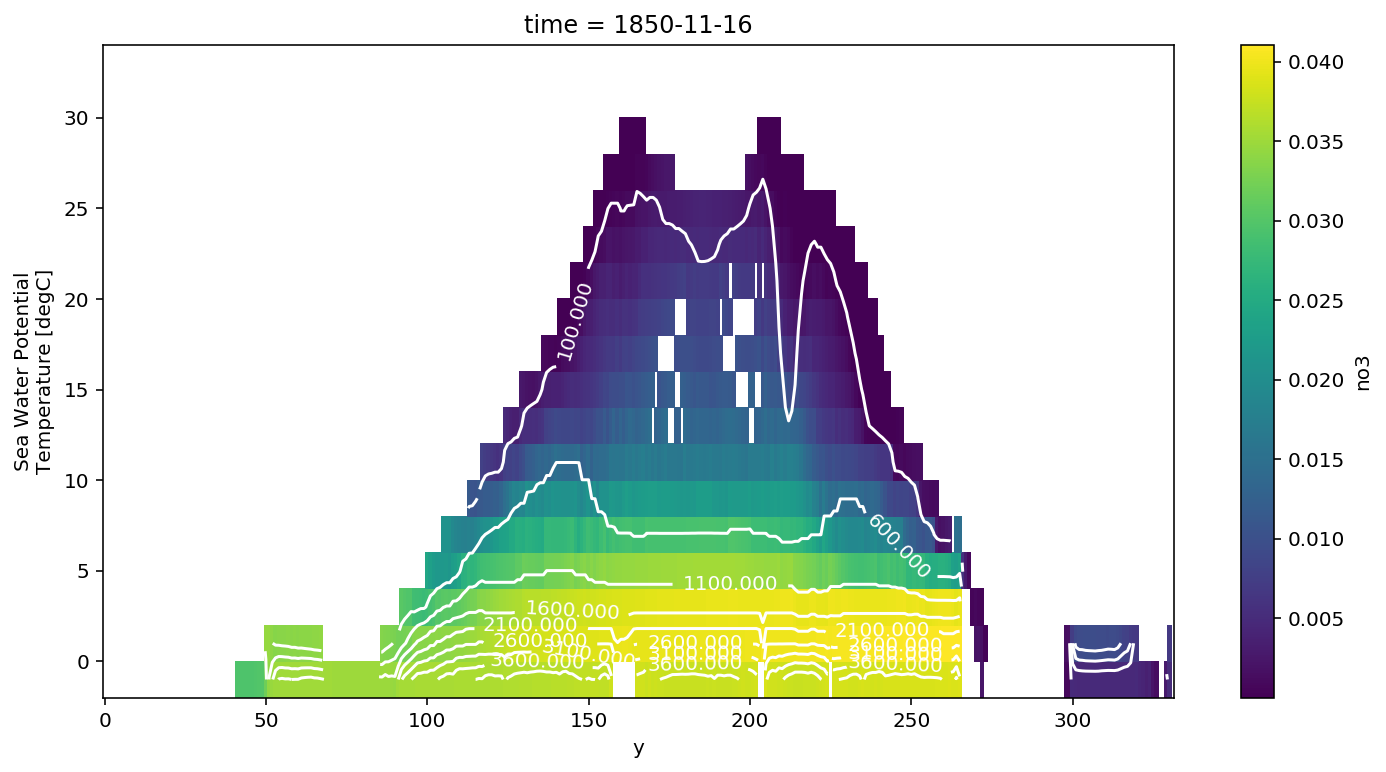

In [142]:
# plot the same slice in temperture coordinates
ds_rebinned.no3.isel(**roi).plot(x='y')

# we can now plot the depth of each isothermal layer as contour
ch = ds_rebinned.z.isel(**roi).plot.contour(
    levels=np.arange(100,5000,500),
    colors='w',
    x='y'
)
plt.clabel(ch)